In [ ]:
!pip install yfinance plotly keras tensorflow prophet

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import yfinance as yf
from prophet import Prophet
from prophet.plot import plot_plotly

In [ ]:
IBM_data = yf.download('IBM', start='2006-01-01' , end='2022-12-30')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
training_set_df = IBM_data[:'2016'].iloc[:,1:2]
test_set_df = IBM_data['2017':].iloc[:,1:2]
training_set = training_set_df.values
test_set = test_set_df.values

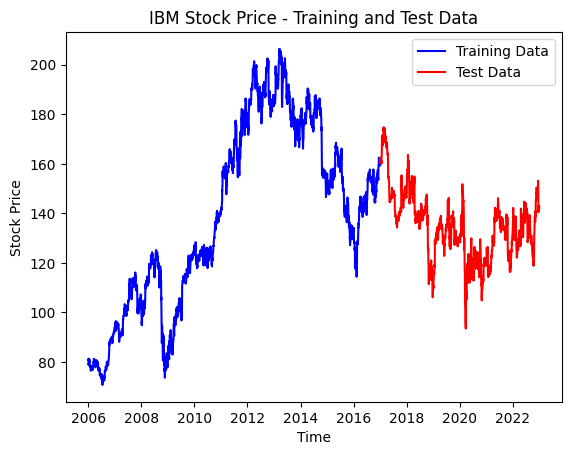

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have training_set and test_set

# Plotting training data in blue
plt.plot(training_set_df, color='blue', label='Training Data')

# Plotting test data in red
plt.plot(test_set_df, color='red', label='Test Data')

plt.title('IBM Stock Price - Training and Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)


In [ ]:

def create_dl_train_test_split(all_data):
    '''
    input:
      all_data: dataframe with dates and price data

    output:
      X_train: data from 2006-2017
      y_train: data from 2017-2018
      X_test:  data from 2017-2018
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    training_set = all_data[:'2016'].iloc[:,1:2].values
    test_set = all_data['2017':].iloc[:,1:2].values

    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)

    # create training and test data
    X_train = []
    y_train = []
    for i in range(60,2768):
        X_train.append(training_set_scaled[i-60:i,0])
        y_train.append(training_set_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    total_data = pd.concat((all_data["High"][:'2016'], all_data["High"]['2017':]),axis=0)
    inputs = total_data[len(total_data)-len(test_set) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(60,311):
        X_test.append(inputs[i-60:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train, X_test, sc

In [ ]:
X_train, y_train, X_test, sc = create_dl_train_test_split(IBM_data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
def create_single_layer_small_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)


    return model, test_preds

In [ ]:

def create_single_layer_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [ ]:
def create_rnn_model(X_train, y_train, X_test, sc):
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import SGD

def create_GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    regressorGRU.compile(optimizer=optimizer, loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import SGD

def create_GRU_with_drop_out_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    regressorGRU.compile(optimizer=optimizer, loss='mean_squared_error')

    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price


In [ ]:
def create_prophet_results(all_data,
                           final_train_idx=2768,
                           pred_periods=250):
    '''
    create prophet model trained on first 2768 rows by
    default and predicts on last 250 rows
    '''
    # Pull train data
    train_data = all_data[:final_train_idx].reset_index()[['Date', 'High']]
    train_data.columns = ['ds', 'y']

    # Create and fit model
    prophet_model = Prophet()
    prophet_model.fit(train_data)

    # Provide predictions
    test_dates = prophet_model.make_future_dataframe(periods=pred_periods)
    forecast_prices = prophet_model.predict(test_dates)
    return forecast_prices['trend'].values

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from prophet import Prophet

# Define the stock symbol and download historical data
symbol = 'IBM'
data = yf.download(symbol, start='2006-01-01', end='2022-12-30')

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=data.index)

# Add actual stock prices to the DataFrame
results_df['Actual'] = data['High']

# Create and add predictions from different models
X_train, y_train, X_test, sc = create_dl_train_test_split(data)

# Add predictions from your custom models
model_rnn_single, preds_rnn_single = create_rnn_model(X_train, y_train, X_test, sc)
model_rnn, preds_rnn = create_rnn_model(X_train, y_train, X_test, sc)
model_gru, preds_gru = create_GRU_model(X_train, y_train, X_test, sc)
model_gru_dropout, preds_gru_dropout = create_GRU_with_drop_out_model(X_train, y_train, X_test, sc)

results_df['RNN_Single'] = pd.Series(preds_rnn_single.squeeze(), index=results_df.index[-len(preds_rnn_single):])
results_df['RNN'] = pd.Series(preds_rnn.squeeze(), index=results_df.index[-len(preds_rnn):])
results_df['GRU'] = pd.Series(preds_gru.squeeze(), index=results_df.index[-len(preds_gru):])
results_df['GRU_Dropout'] = pd.Series(preds_gru_dropout.squeeze(), index=results_df.index[-len(preds_gru_dropout):])
prophet_preds = create_prophet_results(data)
results_df['Prophet'] = pd.Series(prophet_preds, index=results_df.index[-len(prophet_preds):])

[*********************100%%**********************]  1 of 1 completed
Epoch 1/100
19/19 [==============================] - 15s 187ms/step - loss: 0.0995
Epoch 2/100
19/19 [==============================] - 4s 222ms/step - loss: 0.0213
Epoch 3/100
19/19 [==============================] - 5s 283ms/step - loss: 0.0310
Epoch 4/100
19/19 [==============================] - 4s 185ms/step - loss: 0.0179
Epoch 5/100
19/19 [==============================] - 4s 189ms/step - loss: 0.0258
Epoch 6/100
19/19 [==============================] - 6s 306ms/step - loss: 0.0176
Epoch 7/100
19/19 [==============================] - 4s 193ms/step - loss: 0.0157
Epoch 8/100
19/19 [==============================] - 4s 189ms/step - loss: 0.0167
Epoch 9/100
19/19 [==============================] - 6s 297ms/step - loss: 0.0163
Epoch 10/100
19/19 [==============================] - 4s 189ms/step - loss: 0.0125
Epoch 11/100
19/19 [==============================] - 4s 186ms/step - loss: 0.0113
Epoch 12/100
19/19 [======

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp18impmhg/x66bxr5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp18impmhg/a1tih08q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82269', 'data', 'file=/tmp/tmp18impmhg/x66bxr5_.json', 'init=/tmp/tmp18impmhg/a1tih08q.json', 'output', 'file=/tmp/tmp18impmhg/prophet_model92sy_xeh/prophet_model-20231211023653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} MSE: {mse:.4f}")
    print(f"{model_name} R2: {r2:.4f}")
    print()


In [ ]:
import numpy as np

# Assuming 'Actual', 'RNN_Single', 'RNN', 'GRU', 'GRU_Dropout', 'Prophet' are columns in results_df

# Replace NaN values with zeros or any other appropriate value
results_df.fillna(0, inplace=True)

# Now, you can proceed with evaluating the models
evaluate_model(results_df['Actual'], results_df['RNN_Single'], 'RNN_Single')
evaluate_model(results_df['Actual'], results_df['RNN'], 'RNN')
evaluate_model(results_df['Actual'], results_df['GRU'], 'GRU')
evaluate_model(results_df['Actual'], results_df['GRU_Dropout'], 'GRU_Dropout')
evaluate_model(results_df['Actual'], results_df['Prophet'], 'Prophet')


RNN_Single MSE: 18858.7305
RNN_Single R2: -18.5308

RNN MSE: 18845.2830
RNN R2: -18.5168

GRU MSE: 18848.0005
GRU R2: -18.5197

GRU_Dropout MSE: 18846.3747
GRU_Dropout R2: -18.5180

Prophet MSE: 5355.4607
Prophet R2: -4.5463

